<a href="https://colab.research.google.com/github/MJMortensonWarwick/AI-DL/blob/main/2_1_convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
This tutorial will walk through a CNN in Keras. We will be working with a chest x-ray set from Kaggle ([here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)) where we are predicting whether a paitent has pneumonia or not. 

To get the data we need an API key from Kaggle. Set up an account (if you haven't got one already) and then click on your avatar in the top right and "Account" from the dropdown menu. Scroll down the page and you'll find a button to "Create New API Token". This downloads an API key to your PC which you can upload here.

In [ ]:
from google.colab import files
files.upload()

Next we need to move this to a folder called kaggle as this is where Colab will look (Linux commands): 

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Now you can download the data. The following can be used for any Kaggle dataset. When you are on the dataset page click the three vertical dots on the right and select "Copy API command". This gives you code that looks like below (but add a "!" at the start):

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:10<00:00, 221MB/s]
100% 2.29G/2.29G [00:10<00:00, 229MB/s]


This has added the data as a zip folder. We can unzip it and create a new folder (Linux again):

In [ ]:
!unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

For ease we will create some variables to store the path to the directories:

In [5]:
train_dir = "/content/chest-xray-pneumonia/chest_xray/train"
test_dir = "/content/chest-xray-pneumonia/chest_xray/test"
val_dir = "/content/chest-xray-pneumonia/chest_xray/val"

Now we can add a generator to create augmentations. For test and validation we just want to normalise (divide by 255 pixels):

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

Finally we can create our dataset variables with a batch size of 16. We'll also shrink down the images to 64x64 pixels:

In [8]:
batch_size = 16
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (64, 64), 
                                                 batch_size = batch_size, 
                                                 class_mode = "binary")
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size = (64, 64),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Noew we can build our model:

In [9]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D 

cnn = Sequential()

In [10]:
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(64, 64, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2, padding='SAME'))
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2, padding='SAME'))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(1, activation='sigmoid'))

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                        

Nearly a million parameters to learn! We better get busy:

In [12]:
from keras import losses

cnn.compile(optimizer = 'adam', 
            loss = losses.BinaryCrossentropy(), 
            metrics = ['Recall'])

history = cnn.fit(training_set, validation_data = val_set, epochs = 10)

Epoch 1/10
326/326 [==============================] - 83s 210ms/step - loss: 0.3960 - recall: 0.8988 - val_loss: 5.1821 - val_recall: 1.0000
Epoch 2/10
326/326 [==============================] - 67s 207ms/step - loss: 0.2798 - recall: 0.9117 - val_loss: 0.6460 - val_recall: 0.7500
Epoch 3/10
326/326 [==============================] - 67s 207ms/step - loss: 0.2603 - recall: 0.9280 - val_loss: 1.0121 - val_recall: 0.0000e+00
Epoch 4/10
326/326 [==============================] - 68s 210ms/step - loss: 0.2636 - recall: 0.9257 - val_loss: 4.8764 - val_recall: 0.0000e+00
Epoch 5/10
326/326 [==============================] - 68s 208ms/step - loss: 0.2241 - recall: 0.9404 - val_loss: 0.6945 - val_recall: 1.0000
Epoch 6/10
326/326 [==============================] - 67s 206ms/step - loss: 0.2065 - recall: 0.9445 - val_loss: 2.6282 - val_recall: 1.0000
Epoch 7/10
326/326 [==============================] - 67s 207ms/step - loss: 0.2192 - recall: 0.9417 - val_loss: 0.7418 - val_recall: 0.3750
Epoch

Let's visualise the results:

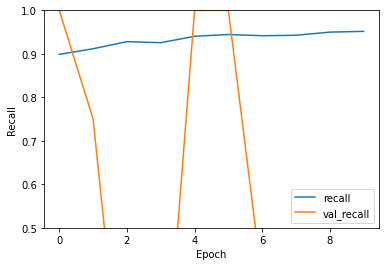

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can see recall on the training set has steadily improved. On the validation set its all over the place but then that's only 16 images. Let's see how we do on test:

In [14]:
test_loss, test_recall = cnn.evaluate(test_set)

39/39 [==============================] - 6s 163ms/step - loss: 0.7300 - recall: 0.4769


Only 48%. Our model probably needs more work (training) but we have a result at least and that's all we need right now! 🍺